In [212]:
import numpy as np
import pandas as pd
import scipy
import networkx as nx
from networkx.generators.random_graphs import erdos_renyi_graph
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [66]:
def cockroach_gen(v):
    n = 4 * v
    dia = np.ones(n-1)
    upperG = np.diag(dia, k=1)
    LowerG = np.diag(dia, k=-1)
    G = upperG + LowerG

    for i in range(v,2*v):
        G[i, n-1-i] = 1
        G[n-1-i, i] = 1

    #G = np.asmatrix(G)
    return G

In [214]:
def eigen_finder(eval, evec, k):
    # sort eigen values and eigen vectors
    idx = eval.argsort()[::1]   
    eval = eval[idx]
    evec = evec[:, idx]

    #print(eval, '\n', evec)

    copy_val = deepcopy(eval)
    copy_val = copy_val.round(decimals=10)
    idx = np.where(copy_val == 0)[0][-1]+1

    k_eval = eval[idx:idx+k]
    k_vec = evec[:, idx:idx+k]
    
    #print(k_eval, '\n',k_vec)

    return k_eval, k_vec
    

In [215]:
def Graph_Cut(A, cut_type='ratio_cut', cluster_type='kmeans', k=2): # adjacency matrix

    # Calculate Laplacian
    dii = A.sum(axis=1)
    D = np.diag(dii)
    L = D - A

    if cut_type == 'ratio_cut':
        eval, evec = np.linalg.eig(L)
    
    elif cut_type == 'rw_ncut':
        L_rw = np.linalg.inv(D) @ L
        eval, evec = np.linalg.eig(L_rw)
    
    elif cut_type == 'sym_ncut':
        L_sym = D**(1/2) @ L @ D**(1/2)
        eval, evec = np.linalg.eig(L_sym)


    if cluster_type == 'sign': # we use sign of f as indicator
        eval, evec = eigen_finder(eval, evec, 1)
        cluster = np.where(evec>=0, 1, 0)
        return cluster

    elif cluster_type == 'kmeans': # we use k-means cluster
        if k==2:
            eval, evec = eigen_finder(eval, evec, 1)
        else:
            eval, evec = eigen_finder(eval, evec, k)
        if cut_type == 'sym_ncut':
            evec = normalize(evec, axis=1, norm='l1')
        kmeans = KMeans(n_clusters=k).fit(evec) # , n_init="auto"
        return kmeans.labels_

    

In [287]:
def print_results(G, cluster):

    k = len(np.unique(cluster))
    
    cl = list()
    for i in range(k):
        cl.append(np.where(cluster==i)[0].tolist())

    pos = nx.kamada_kawai_layout(G)
    cmap = plt.get_cmap("inferno")
    cmap = cmap(np.linspace(0, 1, k))
    for i in range(k):
        nx.draw_networkx_nodes(G, pos, nodelist=cl[i], node_color=cmap[i], node_size=200)
    #nx.draw_networkx_nodes(G, pos, nodelist=cl2, node_color="tab:blue")

    # edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    plt.show()

/Users/jy/Codes/Homeworks/CSE 8803 NDA/.venv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


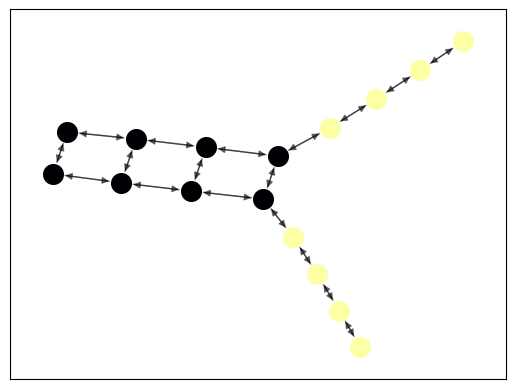

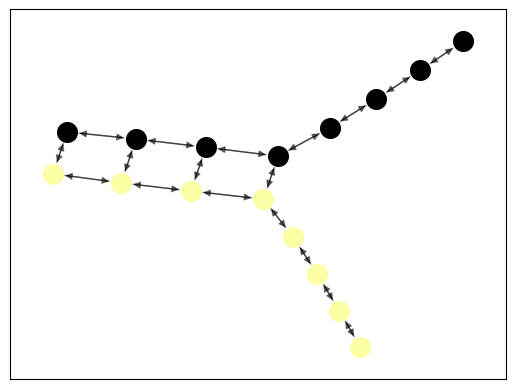

In [297]:
t = ['ratio_cut','rw_ncut','sym_ncut']
# G = erdos_renyi_graph(6, 0.5, seed=11)
# A = nx.adjacency_matrix(G).todense()
# print(A)
# pos = nx.kamada_kawai_layout(G)
# nx.draw(G, pos)
# plt.show()

A = cockroach_gen(4)
G = nx.DiGraph(A)

cluster1 = Graph_Cut(A, cut_type='ratio_cut', cluster_type='sign', k=2)
cluster2 = Graph_Cut(A, cut_type='sym_ncut', cluster_type='sign', k=2)
cluster1 = np.array([1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1])
print_results(G, cluster1)
print_results(G, cluster2)

